In [1]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
from helpers import *


In [3]:
DATA_FOLDER = "../Data/"
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID":parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

In [4]:
actors = actors_load.copy()
movies = movies_load.copy()

In [5]:
actors = actors.query("numMovies >=10")
len(actors)

9437

In [6]:
actors_exp = explode_on_movies(actors)

In [13]:
actors_min_movies

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,yearOfBirth,fbID,ageAtMovieRelease,category,winner,numMovies,genres,releaseMonth,releaseYear,genresLen,LastMovie
26,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/04ld76k,28.0,None,None,52,"{Adventure, Crime, Action, Thriller, Drama}",NaN,1959.0,5,False
61,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/0gzy02,30.0,None,None,52,"{Drama, Action, Adventure, War}",4.0,1961.0,4,False
50,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/0bbgvp,32.0,None,None,52,"{Adventure, Action, Drama, History, Romance}",11.0,1962.0,5,False
51,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/0c01km0,33.0,None,None,52,{Comedy},6.0,1964.0,1,False
28,/m/010xjr,Richard Harris,M,1930-10-01,1.85,Irish people,1930.0,/m/05_mbv,33.0,None,None,52,"{Drama, World}",NaN,1964.0,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219089,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/0h33rzv,44.0,None,None,54,"{Horror, Comedy, Fiction, Mystery, Fantasy, Th...",1.0,2012.0,6,False
219088,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/0gtvrv3,44.0,None,None,54,"{Drama, Crime, Fantasy}",5.0,2012.0,3,False
219086,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/0gj8t_b,45.0,None,None,54,"{Musical, Comedy, Drama, Romance}",6.0,2012.0,4,False
219087,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.74,NaN,1967.0,/m/0gkyxjc,46.0,None,None,54,"{Comedy, Animation, Adventure}",7.0,2013.0,3,False


In [7]:
actors_movies = actors_exp.merge(
    movies[["fbID", "genres", "releaseMonth", "releaseYear"]], how="left", on="fbID"
)
actors_movies_sort = actors_movies.sort_values(
    by=["fbActorID", "ageAtMovieRelease", "releaseYear", "releaseMonth"]
)
actors_min_movies = actors_movies_sort.query("numMovies >=20")
actors_min_movies = actors_min_movies[
    ~(actors_min_movies.ageAtMovieRelease.isna() & actors_min_movies.releaseYear.isna())
]
actors_min_movies = actors_min_movies[~actors_min_movies.genres.isna()]
actors_min_movies["genresLen"] = actors_min_movies.genres.apply(lambda x: len(x))
actors_min_movies["LastMovie"] = np.array(
    [
        *(
            actors_min_movies.fbActorID[1:].values
            != actors_min_movies.fbActorID.values[:-1]
        ),
        True,
    ]
)
genreslist = actors_min_movies.genres.explode().value_counts().index

In [8]:
exploded_actors_genres = actors_min_movies.explode("genres")

In [9]:
# Create dummy variables for genres using one-hot encoding
genre_dummies = pd.get_dummies(
    exploded_actors_genres[["fbActorID", "genres", "genresLen", "fbID","LastMovie"]],
    columns=["genres"],
    prefix="",
    prefix_sep="",
)

genre_dummies[genreslist] = (1 * genre_dummies[genreslist]).div(
    genre_dummies["genresLen"], axis=0
)

# Group by fbActorID and aggregate data, summing up occurrences of each genre
actor_genre_counts = (
    genre_dummies
    .groupby(["fbActorID", "fbID", "LastMovie"], sort=False)
    .agg({genre: "sum" for genre in genreslist})
)

actor_genre_counts= actor_genre_counts.reset_index(level="LastMovie")

actor_genre_counts["numMovieWithGenre"] = np.ones(len(actor_genre_counts)).astype(int)

actor_genre_cum = actor_genre_counts.groupby(
            actor_genre_counts["LastMovie"].shift(1, fill_value=0).cumsum(),
        ).cumsum()

actor_genre_cum["NHHI"] = (1 - (
    (
        (actor_genre_cum[genreslist]).div(actor_genre_cum["numMovieWithGenre"], axis=0)
        ** 2
    ).sum(axis=1)
    - 1 / len(genreslist)
) / (1 - 1 / len(genreslist))).astype(float)

actor_NHHI = actor_genre_cum.drop(columns=[*genreslist,"LastMovie"])

actor_NHHI_20 = actor_NHHI.query("numMovieWithGenre<=50")

actor_NHHI_20.reset_index()

NHHI_series = (
    actor_NHHI_20.droplevel("fbID")
    .reset_index()
    .pivot_table(index="fbActorID", columns="numMovieWithGenre", values="NHHI")
)

NHHI_series

numMovieWithGenre,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
fbActorID,,,,,,,,,,,,,,,,,,,,,
/m/010xjr,0.832000,0.845000,0.867822,0.878150,0.888576,0.897867,0.902324,0.863633,0.891661,0.896688,...,0.918955,0.918003,0.917075,0.917227,0.919986,0.921249,0.915025,0.918120,0.921093,0.919277
/m/0112yl,0.866667,0.845000,0.876296,0.877113,0.888917,0.885557,0.879030,0.887997,0.891530,0.897123,...,0.899451,0.897303,0.899989,0.899261,0.901383,0.902073,0.901878,NaN,NaN,NaN
/m/011_3s,0.891429,0.835714,0.888677,0.912321,0.906451,0.857152,0.797013,0.822721,0.829295,0.855462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/m/011_nf,0.780000,0.715000,0.808889,0.861250,0.856267,0.861852,0.860771,0.854931,0.832785,0.834022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/m/011_pk,0.780000,0.780000,0.823333,0.859625,0.863547,0.848772,0.870853,0.885502,0.866753,0.856783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/m/0tj9,0.693333,0.736667,0.828148,0.845000,0.818133,0.812099,0.851338,0.863056,0.890348,0.891604,...,0.896746,0.896803,0.897958,0.895894,0.899433,0.895799,0.895684,0.895270,0.894774,0.893532
/m/0ywqc,0.520000,0.715000,0.852222,0.891042,0.910000,0.911204,0.908231,0.914740,0.922483,0.913611,...,0.933911,0.933488,0.935123,0.935963,0.936201,0.936744,0.936148,0.936503,0.935751,0.936310
/m/0z05l,0.520000,0.780000,0.843556,0.911300,0.923312,0.930559,0.927286,0.932145,0.940915,0.928194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


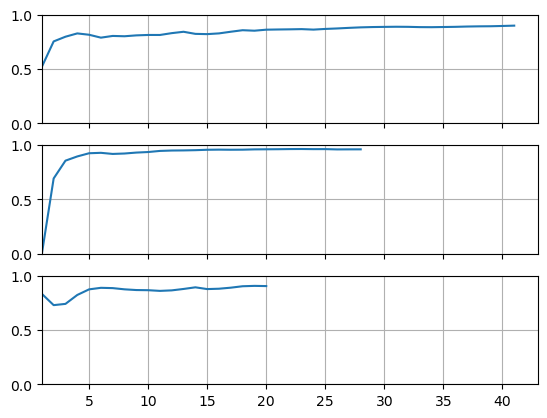

In [10]:
_, axes = plt.subplots(3,1, sharex=True)
profiles =[9,11,18]
for i in range(3):
    axes[i].plot(NHHI_series.iloc[profiles[i]])
    axes[i].grid()
    axes[i].set_ylim([0,1])
    axes[i].set_xlim(1)

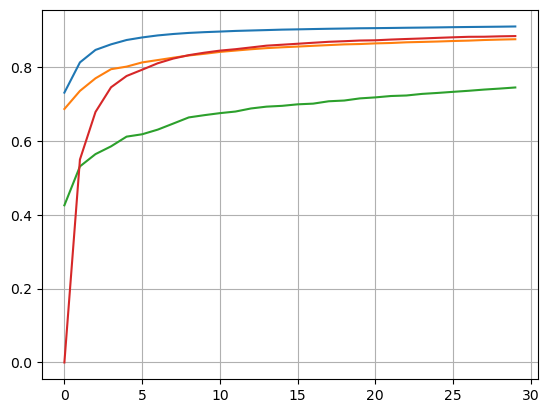

In [11]:
NHHI_series_arr = NHHI_series.drop(columns=np.arange(31,51)).dropna().to_numpy()

GMM = GaussianMixture(n_components=4, n_init=20, random_state=1).fit(NHHI_series_arr)
plt.plot(GMM.means_.T)
plt.grid()

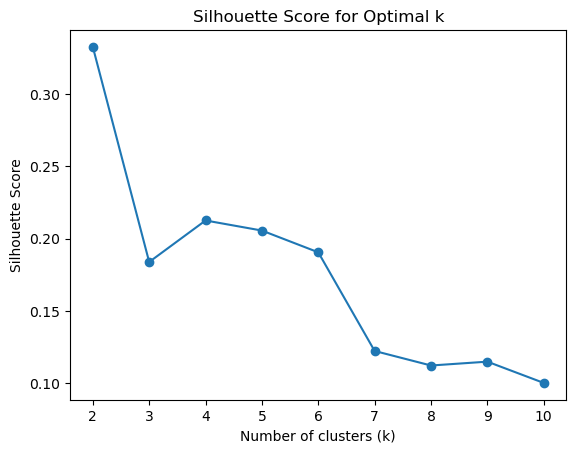

In [12]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, n_init=20, random_state=1)
    labels = kmeans.fit_predict(NHHI_series_arr)
    silhouette_scores.append(silhouette_score(NHHI_series_arr, labels))

# Plotting the Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()